# 1. Building a Convolutional Neural Network Binary Image Classification Model

Train a CNN to classify images of chest x-rays as normal or pneumonia.

Data downloaded from: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download

# 2. Data Exploration

Analyze the dataset to check for class imbalances and size of training, validation, and test sets.

In [2]:
import os

'''
images are arranged in this way:

root/train/NORMAL/xxx.jpeg
root/train/PNEUMONIA/xxx.jpeg

root/val/NORMAL/xxx.jpeg
root/val/PNEUMONIA/xxx.jpeg

root/test/NORMAL/xxx.jpeg
root/test/PNEUMONIA/xxx.jpeg
''' 

root = '/Users/sean/Downloads/chest_xray'

def count_jpeg_files(path):
    return sum([1 for _, _, files in os.walk(path) for f in files if f.endswith('jpeg')])

for dataset in ['train', 'val', 'test']:
    n = count_jpeg_files(os.path.join(root, dataset))
    n_normal = count_jpeg_files(os.path.join(root, dataset, 'NORMAL'))
    n_pneumonia = count_jpeg_files(os.path.join(root, dataset, 'PNEUMONIA'))
    print(f"{dataset} samples: {n}")
    print(f"\tnormal samples: {n_normal}")
    print(f"\tpneumonia samples: {n_pneumonia}")

train samples: 5216
	normal samples: 1341
	pneumonia samples: 3875
val samples: 16
	normal samples: 8
	pneumonia samples: 8
test samples: 624
	normal samples: 234
	pneumonia samples: 390


# 3. Data Preprocessing

Convert the 1-channel (grayscale) images to 2-dimensional tensors so they can be used as input to the CNN.

To reduce training time, we will downscale all the images to a resolution of 256x256, which is a commonly-used standard for CNN-based image classification (https://www.medrxiv.org/content/10.1101/2021.07.30.21261225v1.full).

Also, because the validation set is so small, we will combine the training and validation sets and perform our own 80-20 train-val split.

In [3]:
import shutil
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch

# merge the training and validation sets
def move_files(source_dir, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
        
    for f in os.listdir(source_dir):
        shutil.move(os.path.join(source_dir, f), dest_dir)

move_files(os.path.join(root, 'val', 'NORMAL'), os.path.join(root, 'train', 'NORMAL'))
move_files(os.path.join(root, 'val', 'PNEUMONIA'), os.path.join(root, 'train', 'PNEUMONIA'))
shutil.rmtree(os.path.join(root, 'val'))

In [4]:
# resize grayscale image to 256 x 256, convert to tensor, and normalize pixel values from 0-255 to 0-1
resize_and_normalize = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_and_val_set = datasets.ImageFolder('/Users/sean/Downloads/chest_xray/train', transform=resize_and_normalize)
test_set = datasets.ImageFolder('/Users/sean/Downloads/chest_xray/test', transform=resize_and_normalize)

[train_set, val_set] = torch.utils.data.random_split(train_and_val_set, [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=6, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False, num_workers=6, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=6, drop_last=False)

# 4. Define the Neural Network

We will use a simple feed-forward neural network architecture with two convolutional layers and two fully connected layers. For the convolutional layers, we will use the ReLU activation function. For the output layer, we will use the sigmoid activation function to produce a probability score that the chest x-ray image is pneumonia.

#### Detailed architecture:
1. **Input layer:** 256 x 256 grayscale image
2. **Convolutional layer:** 32 filters, 3x3 kernel size, ReLU activation function, same padding
3. **Max pooling layer:** 2x2 pool siz
4. **Convolutional layer:** 64 filters, 3x3 kernel size, ReLU activation function, same padding
5. **Max pooling layer:** 2x2 pool size
6. **Flatten layer**
7. **Dense layer:** 128 units, ReLU activation function
8. **Dense layer:** 1 unit, sigmoid activation function (for binary classification)
9. **Output layer:** binary classification output


![cnn architecture](nn.svg)

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        
        # fully connected layers
        self.fc1 = nn.Linear(64 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

net = Net()

# 5. Define a Loss Function and Optimizer

The loss function calculates the difference between the predicted outputs and the actual outputs for a given set of training data. It is essentially a measure of how well the model fits the data.

During training, the parameters (e.g. weights, biases, filters) of the model are adjusted to minimize the loss function using backpropagation and an optimizer. The optimizer is an algorithm that updates the  model parameters after each batch, or training cycle, in the direction of the negative gradient of the loss function.

This optimization process is repeated over many batches and the loss function decreases over time until the network achieves the desired performance or begins to overfit. How quickly the model converges depends on parameters such as learning rate and momentum.

For simplicity, we will be using binary cross-entropy loss function and stochastic gradient descent (SGD) optimizer.

In [6]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 6. Train the Network

Define a training loop to optimize the parameters (weights and biases) in the CNN. In the outer loop, we define how many times we want to loop over the training dataset. Each iteration is known as an epoch.

Within each epoch, we load the training data in batches. For each batch, we repeat the following steps:
1. Send the batch of inputs (images) through the model to generate outputs (a list of values between 0-1 which represents the probabilities each image is pneumonia).
2. Calculate the batch loss by comparing the outputs to the true labels
3. Use backward propagation to calculate the gradients
4. Update the weights using the calculated gradients

We will be training the CNN over 10 epochs and saving the best-performing model as measured by validation loss.

In [7]:
epochs = 10

train_losses = []
val_losses = []
min_val_loss = float('inf')
for epoch in range(epochs):
    
    net.train()
    total_train_loss = 0.0
    for inputs, labels in train_loader:  
        optimizer.zero_grad()
        outputs = net(inputs)
        labels = labels.unsqueeze(1).float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    net.eval()
    total_val_loss = 0.0
    for inputs, labels in val_loader:
        outputs = net(inputs)
        labels = labels.unsqueeze(1).float()
        loss = criterion(outputs, labels)
        total_val_loss += loss.item()
        
    train_loss = total_train_loss / len(train_loader)
    val_loss = total_val_loss / len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if val_loss < min_val_loss:
        torch.save(net.state_dict(), '/Users/sean/Documents/CNN_Image_Classification/model.pt')

    print(f"Epoch {epoch + 1} \t\t Training Loss: {train_loss} \t\t Validation Loss: {val_loss}")

Epoch 1 		 Training Loss: 0.4862185987142416 		 Validation Loss: 0.3414250616915524
Epoch 2 		 Training Loss: 0.25878887205169754 		 Validation Loss: 0.21461988100782037
Epoch 3 		 Training Loss: 0.19510988988555394 		 Validation Loss: 0.18640529364347458
Epoch 4 		 Training Loss: 0.16276605954537024 		 Validation Loss: 0.14998569327872247
Epoch 5 		 Training Loss: 0.13886776861663047 		 Validation Loss: 0.11922987346770242
Epoch 6 		 Training Loss: 0.1254189882857295 		 Validation Loss: 0.12821515637915581
Epoch 7 		 Training Loss: 0.11836662342628608 		 Validation Loss: 0.14856619958300143
Epoch 8 		 Training Loss: 0.11663004563978085 		 Validation Loss: 0.1142649739049375
Epoch 9 		 Training Loss: 0.10871024481379069 		 Validation Loss: 0.10857998440042138
Epoch 10 		 Training Loss: 0.10993829696582487 		 Validation Loss: 0.10977152903797105


## Plot training and validation loss against the number of epochs

Assess the model performance over time in the training process to see if the model begins to overfit or if we can increase the number of epochs and get improved performance.

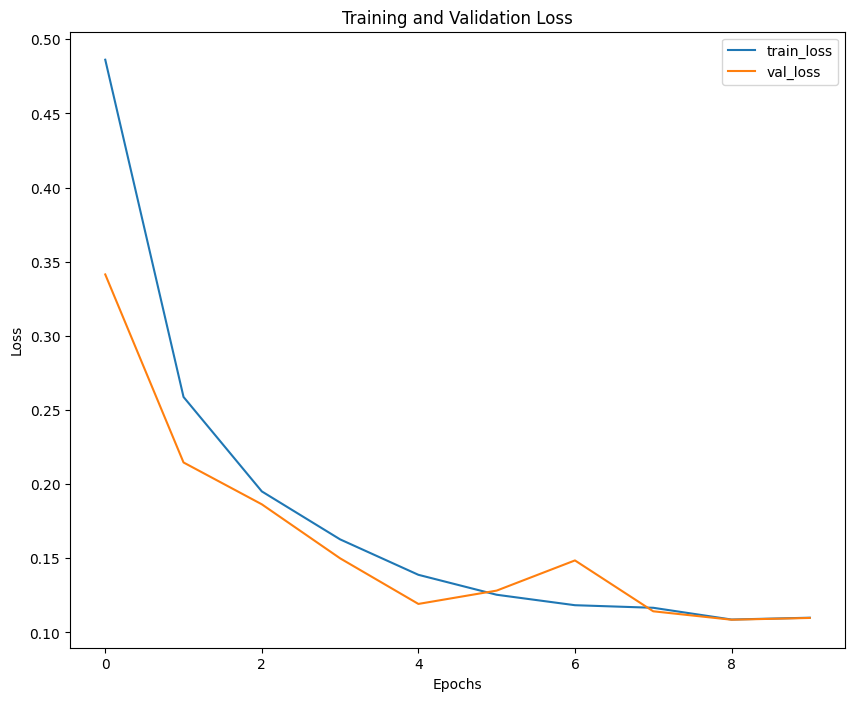

In [8]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 8))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses,label='val_loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 7. Evaluate the Network on Test Data

We will evaluate the model on the test set to estimate how well it performs on unseen data. We will visualize the confusion matrix to summarize the model performance and use metrics such as accuracy, precision, and recall.

Evaluating the model on 624 test images:
Accuracy: 73.00%
Precision: 70.26%
Recall: 98.72%


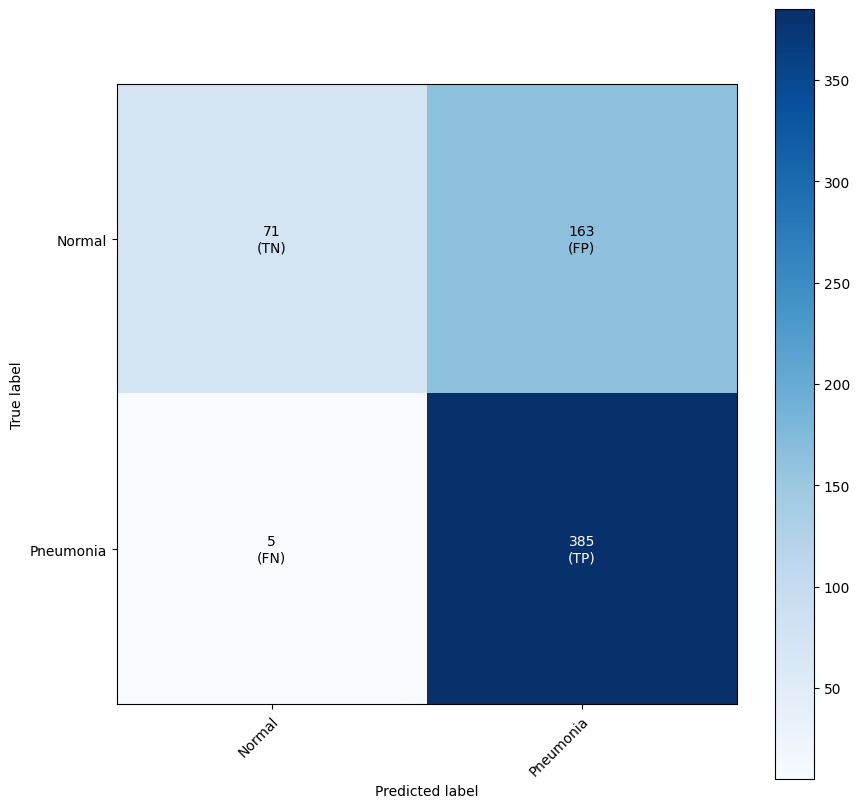

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score

best_net = Net()
best_net.load_state_dict(torch.load('/Users/sean/Documents/CNN_Image_Classification/model.pt'))
best_net.eval()

correct = 0
total = 0
y_true = []
y_pred = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for (inputs, labels) in test_loader:
        # calculate outputs by running images through the network
        outputs = best_net(inputs)
        predicted = (outputs > 0.5).squeeze().float()
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
cm = confusion_matrix(y_true, y_pred)
class_names = ['Normal', 'Pneumonia']

# plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right',
         rotation_mode='anchor')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ''
        if i == j:
            text += 'T'
        else:
            text += 'F'
        if j == 0:
            text += 'N'
        else:
            text += 'P'
        ax.text(j, i, '{}\n({})'.format(cm[i, j], text),
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black')

# calculate model performance metrics on test set
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print(f"Evaluating the model on {total} test images:")
print(f"Accuracy: {(100 * correct // total):.2f}%")
print(f"Precision: {100 * precision:.2f}%")
print(f"Recall: {100 * recall:.2f}%")

# 8. future work

As we can see from our model evaluation, the network can correctly identify most pneumonia cases (high sensitivity/recall/true positive rate) but returns a lot of false positives (low precision, high false positive rate).

The purpose of this notebook is simply to explore deep learning and the process of building + training a neural network. Given more time and resources, we could looko to improve our model by:

- transforming and augmenting images (e.g. random rotation, shifts, shear, flip, etc.) to improve generalization (https://pytorch.org/vision/stable/transforms.html)
- tune model and training hyperparameters to improve model convergence and performance (e.g. batch size, learning rate, momentum, neural network architecture, threshold)
- train the network in the cloud or on a gpu to accelerate training time
  - more epochs/iterations over the training data to continue minimizing the loss function and convere on the best model parameters
  - can make the neural network architecture more complex (e.g. adding convolutional layers) to investigate whether this will improve model performance